# Lectura de datos descargados de www.drogueriascolsubsidio.com

In [1]:
import os
os.chdir(r'C:\Users\Fsalinas\Documents\GitHub\boticarios')

In [6]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

#### Lista de archivos individuales con los datos descargados

In [75]:
url_json = './web_scraping/data/json/20210613/*.json'
archivos = glob.glob(url_json)
print(f'Número de archivos listados: {len(archivos)}')
archivos[:10]

Número de archivos listados: 6959


['./web_scraping/data/json/20210613\\2_PASOS_BANDA_NARIZ_CETTUA_X_3_PARES.json',
 './web_scraping/data/json/20210613\\3A_OFTENO_01_SOLUCIÓN_OFTÁLMICA.json',
 './web_scraping/data/json/20210613\\3_BALLERINAS_TE_POLVO.json',
 './web_scraping/data/json/20210613\\4D_CREMA_TÓPICA.json',
 './web_scraping/data/json/20210613\\A70_ALCOHOL_ANTISEPTICO_70_SOLUCIÓN.json',
 './web_scraping/data/json/20210613\\ABRILAR_07_G100_ML_JARABE.json',
 './web_scraping/data/json/20210613\\abrilar_ea575_jarabe_mentol.json',
 './web_scraping/data/json/20210613\\ABRILAR_JARABE.json',
 './web_scraping/data/json/20210613\\ABSORBABLE_CALCIUM__VITAMINA_D_SOFTGELS.json',
 './web_scraping/data/json/20210613\\ABSORBK_CLARIFICANTE_CREMA.json']

In [76]:
df = pd.concat([pd.read_json(path_or_buf = archivo, orient='index').T for archivo in archivos], axis=0, ignore_index=True)
df.info()
df.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6959 entries, 0 to 6958
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   url_producto         6959 non-null   object
 1   fecha_hora_scraping  6959 non-null   object
 2   breadcumb            6959 non-null   object
 3   titulo               6959 non-null   object
 4   nombre_imagen        6959 non-null   object
 5   presentacion         6959 non-null   object
 6   precio               6959 non-null   object
 7   descripcion          6959 non-null   object
 8   atributos            6959 non-null   object
dtypes: object(9)
memory usage: 489.4+ KB


,url_producto,fecha_hora_scraping,breadcumb,titulo,nombre_imagen,presentacion,precio,descripcion,atributos
0,https://www.drogueriascolsubsidio.com/banda-na...,2021-06-14 08:24:59,colsubsidio|higiene y cuidado personal|cuidado...,2 PASOS BANDA NARIZ CETTUA X 3 PARES,./web_scraping/data/img/2_PASOS_BANDA_NARIZ_CE...,EMPAQUE X 3 PARES,"{'bestPrice': '$17.400', 'precioPorSku js-PUM'...",2 PASOS BANDA NARIZ CETTUA X 3 PARES,"[[Presentación, EMPAQUE X 3 PARES], [Concentra..."
1,https://www.drogueriascolsubsidio.com/3a-often...,2021-06-14 03:57:51,colsubsidio|medicamentos|formulados,3A OFTENO 0.1% SOLUCIÓN OFTÁLMICA,./web_scraping/data/img/3A_OFTENO_01_SOLUCIÓN_...,FRASCO X 5 ML,"{'bestPrice': '$76.450', 'precioPorSku js-PUM'...",este producto es un medicamento. no exceder su...,"[[Presentación, FRASCO X 5 ML], [Concentracion..."
2,https://www.drogueriascolsubsidio.com/3-baller...,2021-06-14 03:33:51,colsubsidio|medicamentos|medicina alternativa|...,3 BALLERINAS TE POLVO,./web_scraping/data/img/3_BALLERINAS_TE_POLVO.jpg,CAJA X 30 SOB,"{'bestPrice': '', 'precioPorSku js-PUM': 'Unid...",3 ballerinas te polvo,"[[Presentación, CAJA X 30 SOB], [Concentracion..."


In [92]:
# df['presentacion2'].apply(lambda x: float(''.join([y for y in x.split(' X ')[1] if y.isdigit()])) if len(x.split(' X '))>=2 else 0)
t = df['presentacion2'].apply(lambda x: x.split('X')).tolist()
tg = pd.DataFrame(t, columns=range(max([len(x) for x in t])))
tg.groupby(0)[1].count()

0
                0
2 CAJASX6TUB    0
2 FRASCOS       1
2 TARRO         2
2 TUBO          2
               ..
UNIDAD X90G     0
UNIDAD X90ML    0
VASO            6
lLATA           1
n               0
Name: 1, Length: 79, dtype: int64

In [108]:
df['nro_categorias'] = [len(x) for x in df['breadcumb'].apply(lambda x: x.split('|')).tolist()]
cols_cat = []
for c in range(1,df['nro_categorias'].max()-1):
    cols_cat += [f'categoria{c}']
    df[f'categoria{c}'] = df['breadcumb'].apply(lambda x: x.split('|')[c] if len(x.split('|'))>c+1 else 'NA').tolist()
    try:
        df[f'categoria{c}'] = df.apply(lambda x: x[f'categoria{c-1}'] if x[f'categoria{c}']=='NA' and c>0 else x[f'categoria{c}'], axis=1)
    except:
        continue

df['presentacion2'] = df['atributos'].apply(lambda x: ':'.join(x[0]).replace('Presentación:', ''))
rpl = {'FRASCO 50 X ML': 'FRASCO X 50 ML', 'BOLSA X PAR': 'BOLSA X 2'}
df['presentacion2'].replace(rpl, inplace=True)

df['precio_actual'] = df['precio'].apply(lambda x: int(x['bestPrice'].replace('$', '').replace('.', '')) if len(x['bestPrice'].replace('$', '').replace('.', ''))>0 else 0)
df['precio_anterior'] = df['precio'].apply(lambda x: int(x['PrevPrice'].replace('$', '').replace('.', '').replace('Antes:', '')) if 'PrevPrice'.lower() in str(x).lower() and len(x['PrevPrice'].replace('$', '').replace('.', '').replace('Antes:', ''))>0 else 0)
df['unidad'] = df['precio'].apply(lambda x: x['precioPorSku js-PUM'].split(' a ')[0])
df['cantidad_total_unidad'] = df['presentacion2'].apply(lambda x: float(''.join([y if y.isdigit() else '' for y in x.split(' X ')[1]])) if len(x.split(' X '))>=2 else 0)
df['vr_x_unidad'] = df['precio'].apply(lambda x: float(x['precioPorSku js-PUM'].split(' a ')[1].replace('$', '').replace('.', '').replace(',', '.')) if len(x['precioPorSku js-PUM'].split(' a '))>1 else float(0))
df['id'] = df['url_producto'].apply(lambda x: x[-15:-2])

In [109]:
df.groupby(cols_cat, as_index=False)['fecha_hora_scraping'].count().rename(columns={'fecha_hora_scraping':'n'}).sort_values(by='n', ascending=False)

,categoria1,categoria2,categoria3,n
13,medicamentos,medicamentos,medicamentos,2157
3,belleza,cosméticos,cosméticos,647
12,medicamentos,dermatológicos,dermatológicos,538
20,nutricion y vida saludable,nutricion y vida saludable,nutricion y vida saludable,419
4,equipos de cuidado en casa,equipos de cuidado en casa,equipos de cuidado en casa,346
14,medicamentos,medicina alternativa,medicina alternativa,316
2,belleza,belleza,belleza,303
7,higiene y cuidado personal,cuidado oral,cuidado oral,237
17,medicamentos,venta libre,botiquin y primeros auxilios,232
1,alimentos y bebidas,alimentos y bebidas,alimentos y bebidas,230


In [110]:
df['unidad'].value_counts(dropna=False)

Mililitro     2130
Gramo         1465
Unidad        1365
Tableta       1279
Capsula        465
Comprimido     114
Sobre           36
Gragea          29
OVULO           25
Metro           16
Miligramo       15
Libra            7
Parche           3
Via              2
Kit              2
Ampolla          2
                 2
Cápsula          1
Tarro            1
Name: unidad, dtype: int64

In [111]:
df.info()
df.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6959 entries, 0 to 6958
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   url_producto           6959 non-null   object 
 1   fecha_hora_scraping    6959 non-null   object 
 2   breadcumb              6959 non-null   object 
 3   titulo                 6959 non-null   object 
 4   nombre_imagen          6959 non-null   object 
 5   presentacion           6959 non-null   object 
 6   precio                 6959 non-null   object 
 7   descripcion            6959 non-null   object 
 8   atributos              6959 non-null   object 
 9   nro_categorias         6959 non-null   int64  
 10  categoria1             6959 non-null   object 
 11  categoria2             6959 non-null   object 
 12  categoria3             6959 non-null   object 
 13  presentacion2          6959 non-null   object 
 14  precio_actual          6959 non-null   int64  
 15  prec

,url_producto,fecha_hora_scraping,breadcumb,titulo,nombre_imagen,presentacion,precio,descripcion,atributos,nro_categorias,categoria1,categoria2,categoria3,presentacion2,precio_actual,precio_anterior,unidad,cantidad_total_unidad,vr_x_unidad,id
0,https://www.drogueriascolsubsidio.com/banda-na...,2021-06-14 08:24:59,colsubsidio|higiene y cuidado personal|cuidado...,2 PASOS BANDA NARIZ CETTUA X 3 PARES,./web_scraping/data/img/2_PASOS_BANDA_NARIZ_CE...,EMPAQUE X 3 PARES,"{'bestPrice': '$17.400', 'precioPorSku js-PUM'...",2 PASOS BANDA NARIZ CETTUA X 3 PARES,"[[Presentación, EMPAQUE X 3 PARES], [Concentra...",4,higiene y cuidado personal,cuidado de la piel,cuidado de la piel,EMPAQUE X 3 PARES,17400,0,Parche,3.0,5800.00,8809496770327
1,https://www.drogueriascolsubsidio.com/3a-often...,2021-06-14 03:57:51,colsubsidio|medicamentos|formulados,3A OFTENO 0.1% SOLUCIÓN OFTÁLMICA,./web_scraping/data/img/3A_OFTENO_01_SOLUCIÓN_...,FRASCO X 5 ML,"{'bestPrice': '$76.450', 'precioPorSku js-PUM'...",este producto es un medicamento. no exceder su...,"[[Presentación, FRASCO X 5 ML], [Concentracion...",3,medicamentos,medicamentos,medicamentos,FRASCO X 5 ML,76450,0,Mililitro,5.0,15290.00,-736085410099
2,https://www.drogueriascolsubsidio.com/3-baller...,2021-06-14 03:33:51,colsubsidio|medicamentos|medicina alternativa|...,3 BALLERINAS TE POLVO,./web_scraping/data/img/3_BALLERINAS_TE_POLVO.jpg,CAJA X 30 SOB,"{'bestPrice': '', 'precioPorSku js-PUM': 'Unid...",3 ballerinas te polvo,"[[Presentación, CAJA X 30 SOB], [Concentracion...",4,medicamentos,medicina alternativa,medicina alternativa,CAJA X 30 SOB,0,0,Unidad,30.0,823.33,-781308001233


<AxesSubplot:xlabel='precio_actual', ylabel='categoria3'>

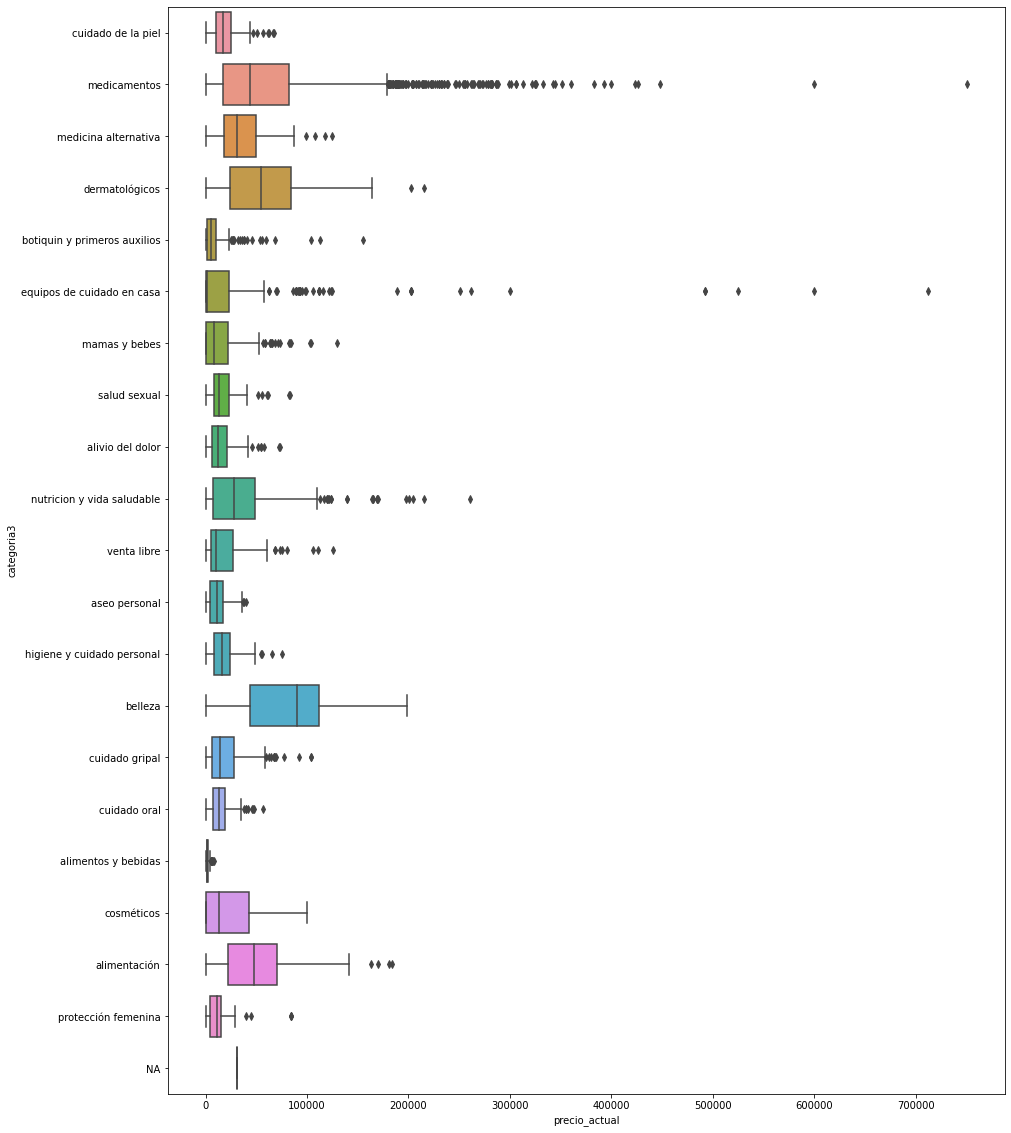

In [113]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,20))
sns.boxplot(data=df, x='precio_actual', y='categoria3', orient='h')

<AxesSubplot:>

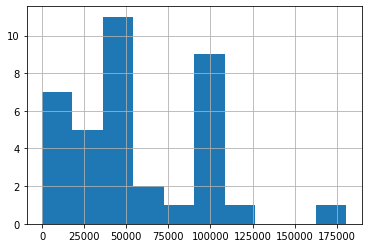

In [54]:
df[df['categoria3'].isin(['alimentación'])]['precio_actual'].hist()

## Lectura de datos desde PostgreSQL

In [114]:
import time
import os
os.chdir(r'C:\Users\Fsalinas\Documents\GitHub\boticarios')
time.sleep(2)
os.chdir('./paquetes')
from connpostgres import conn2
from runSQL import RunDML, RunDDL
time.sleep(2)
os.chdir(r'C:\Users\Fsalinas\Documents\GitHub\boticarios')

In [151]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from tabulate import tabulate

In [122]:
db = conn2('fsalinas', False)
sql = f'''SELECT * FROM web_scraping.drog_colsubsidio2'''
df = RunDDL(sql, db)[0]
db.close()

df['fecha_scraping'] = pd.to_datetime(df['fecha_scraping'], format='%Y-%m-%d')

df.info()
df.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36956 entries, 0 to 36955
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   id              36956 non-null  int64         
 1   url_producto    36956 non-null  object        
 2   fecha_scraping  36956 non-null  datetime64[ns]
 3   hora_scraping   36956 non-null  object        
 4   titulo          36956 non-null  object        
 5   presentacion    36956 non-null  object        
 6   precio_tachado  36956 non-null  float64       
 7   precio_final    36956 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 2.3+ MB


,id,url_producto,fecha_scraping,hora_scraping,titulo,presentacion,precio_tachado,precio_final
0,1,https://www.drogueriascolsubsidio.com/x-ray-do...,2021-06-14,13:55:30,XRAY DOL ANALGÉSICO 12 TABLETAS,CAJA X 12 TAB,0.0,15700.0
1,2,https://www.drogueriascolsubsidio.com/ibuflash...,2021-06-14,13:55:30,IBUFLASH ULTRA FORTE 400 MG/65 MG CAPSULA BLANDA,CAJA X 8 CAP,0.0,11700.0
2,3,https://www.drogueriascolsubsidio.com/dolorsin...,2021-06-14,13:55:30,DOLORSIN 400 MG CAPSULA DURA CON CONTENIDO LIQ...,BLISTER X 4 CAP,5600.0,2800.0


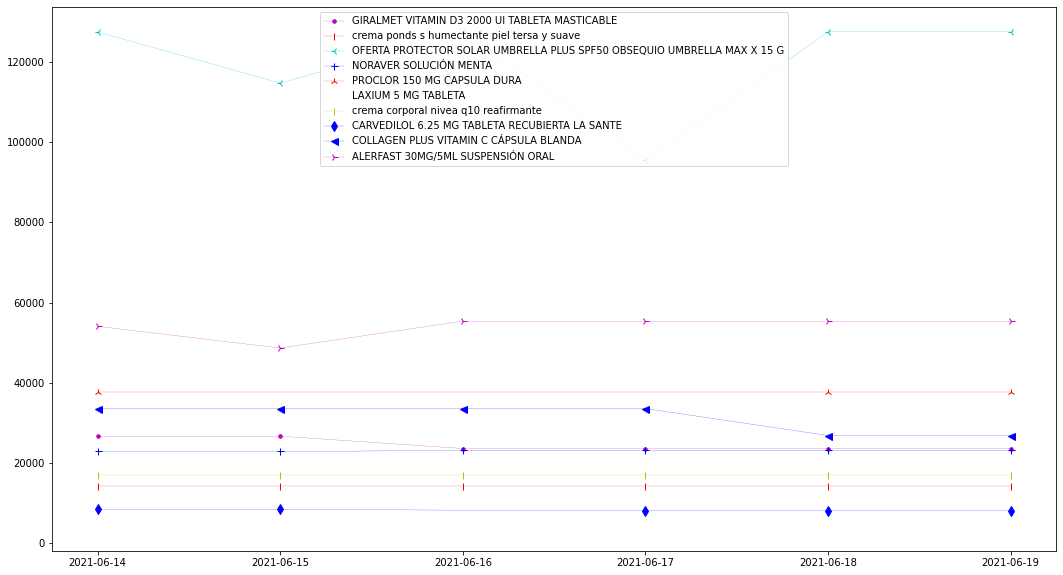

In [251]:
productos = [df.loc[random.randrange(0, df.shape[0]), 'titulo'] for x in range(10)]
# print(f'Producto: {producto}')

tdf1 = df[df['titulo'].isin(productos)].groupby(['fecha_scraping', 'titulo'], as_index=False)['precio_tachado'].sum().rename(columns={'precio_tachado':'precio'})
tdf1['tipo_precio'] = 'precio_tachado'

tdf2 = df[df['titulo'].isin(productos)].groupby(['fecha_scraping', 'titulo'], as_index=False)['precio_final'].sum().rename(columns={'precio_final':'precio'})
tdf2['tipo_precio'] = 'precio_final'

plot_df = pd.concat(
    [
        tdf1,
        tdf2
    ],
    axis=0
).groupby(['fecha_scraping', 'titulo', 'tipo_precio'], as_index=False)['precio'].sum()

# print(tabulate(plot_df, headers='keys', tablefmt='simple'))

def ff(d):
    return pd.to_datetime(d).strftime('%Y-%m-%d')

markers = ['.', ',', 'o', 'v', '^', '<', '>', '1', '2', '3', '4', '8', 's', 'p', 'P', '*', 'h', 'H', '+', 'x', 'X', 'D', 'd', '|', '_']
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(18,10))
for producto in productos:
    filtro = (plot_df['titulo']==producto)&(plot_df['tipo_precio']=='precio_final')
    plot1 = ax.plot(
        plot_df[filtro]['fecha_scraping'].apply(ff).values.tolist(),
        plot_df[filtro]['precio'].values.tolist(),
        color=colors[random.randrange(0, len(colors))],
        marker=markers[random.randrange(0, len(markers))],
        linestyle='-',
        linewidth=0.2,
        markersize=7
    )
#     t1 = ax.set_title(producto)
ax.legend(productos)

In [243]:
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']

25